In [1]:
import pennylane as qml
import numpy as np
from qutip import Bloch
# 定义量子设备，支持状态向量模拟
dev = qml.device("default.qubit", wires=4)




In [2]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 64              # Number of samples for each training step
num_epochs = 1             # Number of training epochs
num_experiences = 10        # Number of experiences
num_classes = 200            # Number of classes in the dataset
train_mb_size= 256            # Number of samples for each training step
eval_mb_size=100            # Number of samples for each evaluation step
memory_size = 2000          # Number of total samples in the memory
q_depth = 4                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
alpha=0.5                   # the weight of the old model in the loss function
temperature=2.0             # temperature for the distillation loss

In [3]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RX_layer(w):
    """Layer of parametrized qubit rotations around the x axis.
    """
    for idx, element in enumerate(w):
        qml.RX(element, wires=idx)

def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def phase_layer(w):
    """Layer of S gates and T gates to flip the phase of the qubits.
    """
    for idx in range(w):
        if idx % 2 == 0:
            qml.S(wires=idx)
        else:
            qml.T(wires=idx)
            
def entangling_layer_3(nqubits):
    """Layer of controlled-Rz gates followed by zz entangling gates. 
    """
    params = np.random.uniform(0, 2*np.pi, (nqubits,))
    for i in range(0, nqubits - 1, 2):
        qml.ctrl(qml.RZ, control=i)(params[i], wires=i + 1)
    for i in range(1, nqubits - 1, 2):
        qml.IsingZZ(params[i],wires=[i, i + 1])

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [4]:
@qml.qnode(dev)
def quantum_state(q_input_features, q_weights_flat):
    """
    计算量子态。
    """
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    
    H_layer(n_qubits)  # 施加 Hadamard 门
    RX_layer(q_input_features)  # 施加 RX 旋转门
    
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    return qml.state()  # 只返回量子态

In [5]:
state = quantum_state(np.random.random(n_qubits), np.random.random(q_depth * n_qubits))
print("量子态: ", state)
print(type(state))

量子态:  [-0.00231479+0.01976943j -0.01837999+0.15697422j -0.02757578+0.23551076j
 -0.04443696+0.3795136j   0.01051442-0.08979838j -0.00596438+0.0509388j
  0.00661741-0.05651594j  0.02209104-0.1886684j  -0.01926369+0.16452141j
  0.0315288 -0.26927157j  0.04787967-0.40891603j  0.05880329-0.50220916j
  0.01399361-0.11951233j  0.04126847-0.35245314j  0.01976584-0.16881005j
  0.01905913-0.16277436j]
<class 'numpy.ndarray'>


Bloch 球坐标:  [0.07613255312794835, -3.469446951953614e-18, -0.007638828997921933]


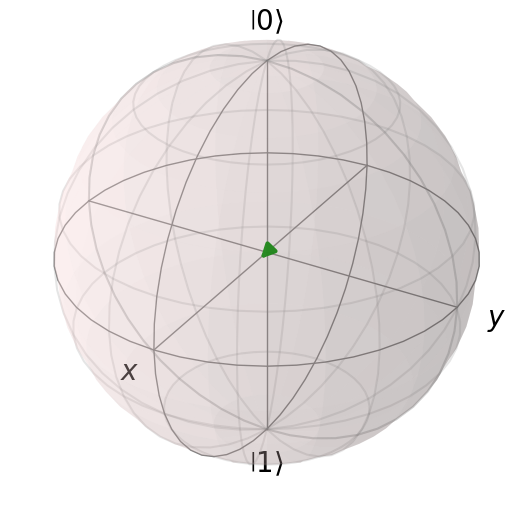

In [6]:
# 计算 Bloch 球坐标
bloch_vector = [2 * np.real(state[0] * np.conj(state[1])),
                2 * np.imag(state[0] * np.conj(state[1])),
                np.real(state[0] * np.conj(state[0]) - state[1] * np.conj(state[1]))]

print("Bloch 球坐标: ", bloch_vector)

# 绘制 Bloch 球
b = Bloch()
b.add_vectors(bloch_vector)  # 添加量子态的 Bloch 坐标
b.show()

In [7]:
@qml.qnode(dev)
def quantum_net_3(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)


    # Sequence of trainable variational layers
    for _ in range(q_depth):
        RX_layer(n_qubits)
        phase_layer(n_qubits)
        entangling_layer_3(n_qubits)
        
    # Measurement layer
    return qml.state()

In [26]:
state = quantum_state(np.random.random(n_qubits), np.random.random(q_depth * n_qubits))
print("量子态: ", state)
print(type(state))

量子态:  [-0.06712032+0.10520451j -0.13555999+0.21247699j -0.16405761+0.2571442j
 -0.23619456+0.3702118j   0.05849463-0.09168459j  0.04284826-0.06716045j
  0.04161838-0.06523273j  0.07408891-0.1161271j   0.11956489-0.18740623j
  0.194037  -0.30413396j  0.1581187 -0.24783554j  0.24331555-0.38137325j
 -0.12542626+0.19659335j -0.03926699+0.06154716j -0.09063738+0.14206519j
  0.09791343-0.1534697j ]
<class 'pennylane.numpy.tensor.tensor'>


Bloch 球坐标:  [0.011263884631751278, -2.6020852139652106e-18, -0.023256359493034368]


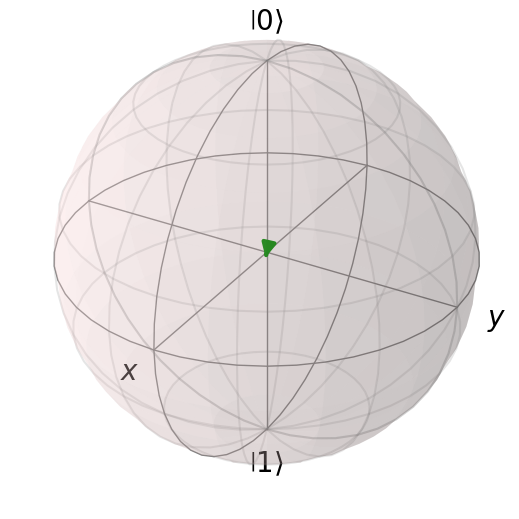

In [9]:
# 计算 Bloch 球坐标
bloch_vector = [2 * np.real(state[0] * np.conj(state[1])),
                2 * np.imag(state[0] * np.conj(state[1])),
                np.real(state[0] * np.conj(state[0]) - state[1] * np.conj(state[1]))]

print("Bloch 球坐标: ", bloch_vector)

# 绘制 Bloch 球
b = Bloch()
b.add_vectors(bloch_vector)  # 添加量子态的 Bloch 坐标
b.show()

In [10]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 64              # Number of samples for each training step
num_epochs = 3              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [12]:
dev = qml.device("default.qubit", wires=n_qubits)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/home/yangz2/code/data/data/hymenoptera_data/hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

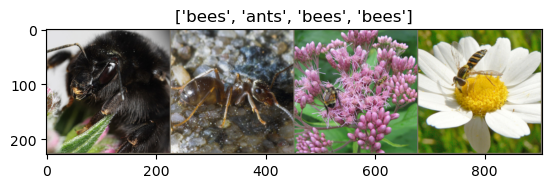

In [15]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [16]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [17]:
@qml.qnode(dev)
def quantum_net_state(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # 返回完整量子态
    return qml.state()

In [18]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """
        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        定义数据在混合量子神经网络中的流动方式。
        """

        # 1️⃣ 【降维】将 ResNet18 的 512 维输出降维为 量子电路输入 (n_qubits 维)
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # 2️⃣ 【计算量子态】并打印出来
        print("\n⚡【量子电路执行】⚡")
        for idx, elem in enumerate(q_in):
            state = quantum_net_state(elem, self.q_params)  # 获取量子态
            print(f"Batch {idx} 量子态: {state}")  # 打印量子态

        # 3️⃣ 【计算 `qml.expval()` 作为 PyTorch 的训练数据】
        q_out = torch.Tensor(0, n_qubits).to(device)
        for elem in q_in:
            state = quantum_net_state(elem, self.q_params)
            q_out_elem = torch.tensor(state[:n_qubits], dtype=torch.float32).unsqueeze(0)  # ✅ 只取前 `n_qubits` 维
            q_out = torch.cat((q_out, q_out_elem), dim=0)


        # 4️⃣ 【输出最终的分类结果】
        return self.post_net(q_out)


In [20]:
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.resnet18(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [21]:
criterion = nn.CrossEntropyLoss()

In [22]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [23]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

In [25]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:

⚡【量子电路执行】⚡
Batch 0 量子态: tensor([0.0888+0.j, 0.5196+0.j, 0.0628+0.j, 0.4665+0.j, 0.3159+0.j, 0.0428+0.j, 0.2832+0.j,
        0.0368+0.j, 0.3131+0.j, 0.0437+0.j, 0.3615+0.j, 0.0609+0.j, 0.0209+0.j, 0.1869+0.j,
        0.0277+0.j, 0.2165+0.j], device='cuda:0', dtype=torch.complex128,
       grad_fn=<UnsafeViewBackward0>)
Batch 1 量子态: tensor([0.3141+0.j, 0.6471+0.j, 0.0380+0.j, 0.0823+0.j, 0.4787+0.j, 0.2270+0.j, 0.0558+0.j,
        0.0257+0.j, 0.0242+0.j, 0.0085+0.j, 0.3142+0.j, 0.1583+0.j, 0.0069+0.j, 0.0183+0.j,
        0.1055+0.j, 0.2324+0.j], device='cuda:0', dtype=torch.complex128,
       grad_fn=<UnsafeViewBackward0>)
Batch 2 量子态: tensor([ 0.0528+0.j,  0.2335+0.j,  0.0121+0.j,  0.0462+0.j,  0.7649+0.j,  0.1444+0.j,
         0.1182+0.j,  0.0255+0.j,  0.0089+0.j, -0.0011+0.j,  0.1463+0.j,  0.0353+0.j,
         0.0073+0.j,  0.0707+0.j,  0.0915+0.j,  0.5327+0.j], device='cuda:0',
       dtype=torch.complex128, grad_fn=<UnsafeViewBackward0>)
Batch 3 量子态: tensor([0.2250

/tmp/ipykernel_211674/3815711595.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem = torch.tensor(state[:n_qubits], dtype=torch.float32).unsqueeze(0)  # ✅ 只取前 `n_qubits` 维
/tmp/ipykernel_211674/3815711595.py:34: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/Copy.cpp:308.)
  q_out_elem = torch.tensor(state[:n_qubits], dtype=torch.float32).unsqueeze(0)  # ✅ 只取前 `n_qubits` 维


Phase: train Epoch: 1/3 Iter: 1/62 Batch time: 1.4606
⚡【量子电路执行】⚡
Batch 0 量子态: tensor([0.1651+0.j, 0.2601+0.j, 0.0691+0.j, 0.1142+0.j, 0.4833+0.j, 0.3012+0.j, 0.1985+0.j,
        0.1225+0.j, 0.0901+0.j, 0.0534+0.j, 0.2525+0.j, 0.1643+0.j, 0.1126+0.j, 0.1952+0.j,
        0.3074+0.j, 0.5116+0.j], device='cuda:0', dtype=torch.complex128,
       grad_fn=<UnsafeViewBackward0>)
Batch 1 量子态: tensor([0.2492+0.j, 0.4145+0.j, 0.0660+0.j, 0.1149+0.j, 0.5172+0.j, 0.3066+0.j, 0.1343+0.j,
        0.0790+0.j, 0.0653+0.j, 0.0358+0.j, 0.3082+0.j, 0.1909+0.j, 0.0502+0.j, 0.0928+0.j,
        0.2298+0.j, 0.4023+0.j], device='cuda:0', dtype=torch.complex128,
       grad_fn=<UnsafeViewBackward0>)
Batch 2 量子态: tensor([0.2915+0.j, 0.5818+0.j, 0.0875+0.j, 0.1867+0.j, 0.5820+0.j, 0.2842+0.j, 0.1793+0.j,
        0.0855+0.j, 0.0412+0.j, 0.0174+0.j, 0.1664+0.j, 0.0856+0.j, 0.0183+0.j, 0.0445+0.j,
        0.0800+0.j, 0.1713+0.j], device='cuda:0', dtype=torch.complex128,
       grad_fn=<UnsafeViewBackward0>)
Batch 3 

Bloch 球坐标:  [tensor(0.2984), tensor(0.), tensor(-0.3393)]


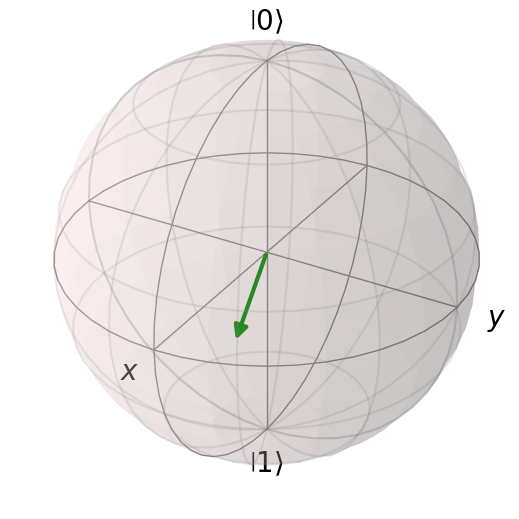

In [ ]:
# list = [0.2372+0.j, 0.6289+0.j, 0.0223+0.j, 0.0605+0.j, 0.5429+0.j, 0.1976+0.j, 0.0462+0.j,
#         0.0167+0.j, 0.0139+0.j, 0.0017+0.j, 0.3221+0.j, 0.1271+0.j, 0.0032+0.j, 0.0143+0.j,
#         0.0965+0.j, 0.2796+0.j]
# tensor = torch.tensor(list, dtype=torch.complex64)
# # 计算 Bloch 球坐标
# bloch_vector = [2 * np.real(tensor[0] * np.conj(tensor[1])),
#                 2 * np.imag(tensor[0] * np.conj(tensor[1])),
#                 np.real(tensor[0] * np.conj(tensor[0]) - tensor[1] * np.conj(tensor[1]))]

# print("Bloch 球坐标: ", bloch_vector)

# # 绘制 Bloch 球
# b = Bloch()
# b.add_vectors(bloch_vector)  # 添加量子态的 Bloch 坐标
# b.show()

In [27]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return


⚡【量子电路执行】⚡
Batch 0 量子态: tensor([ 1.4446e-01+0.j,  3.8322e-01+0.j,  1.1646e-02+0.j,  2.6372e-02+0.j,
         3.8459e-01+0.j,  1.4016e-01+0.j,  2.1475e-02+0.j,  9.7544e-03+0.j,
         7.4756e-03+0.j, -3.7254e-04+0.j,  5.3495e-01+0.j,  2.1142e-01+0.j,
         4.7054e-03+0.j,  1.5113e-02+0.j,  1.8847e-01+0.j,  5.4465e-01+0.j],
       device='cuda:0', dtype=torch.complex128)
Batch 1 量子态: tensor([ 0.4362+0.j,  0.8271+0.j,  0.0160+0.j,  0.0344+0.j,  0.2792+0.j,  0.1418+0.j,
         0.0063+0.j,  0.0010+0.j, -0.0019+0.j, -0.0039+0.j,  0.1366+0.j,  0.0747+0.j,
        -0.0043+0.j, -0.0072+0.j,  0.0180+0.j,  0.0375+0.j], device='cuda:0',
       dtype=torch.complex128)
Batch 2 量子态: tensor([0.0425+0.j, 0.2073+0.j, 0.0207+0.j, 0.1072+0.j, 0.7078+0.j, 0.1114+0.j, 0.3410+0.j,
        0.0541+0.j, 0.0484+0.j, 0.0063+0.j, 0.1224+0.j, 0.0251+0.j, 0.0250+0.j, 0.2232+0.j,
        0.0682+0.j, 0.4875+0.j], device='cuda:0', dtype=torch.complex128)
Batch 3 量子态: tensor([0.1097+0.j, 0.2189+0.j, 0.0440+0.j, 

/tmp/ipykernel_211674/3815711595.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem = torch.tensor(state[:n_qubits], dtype=torch.float32).unsqueeze(0)  # ✅ 只取前 `n_qubits` 维


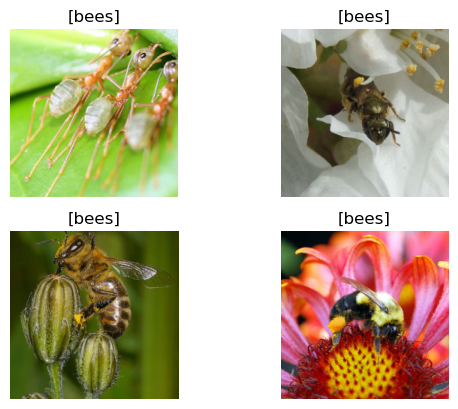

In [28]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()